<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/main_icarl_marco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cloning files needed*

In [2]:
import os
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 231 (delta 5), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (231/231), 888.21 KiB | 7.16 MiB/s, done.
Resolving deltas: 100% (112/112), done.


**Imports**

---

In [0]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim


from PIL import Image
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
from Project_MLDL.model_finetuning import ResNet18
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from tqdm import tqdm

**Arguments**

---





In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 12

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Transformations definition**

---



In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])

*New label function*

In [0]:
DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):       #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
    new_labels=[]
    for el in lbls[:10]:
        new_labels.append(el)
    lbls = lbls[10:]

    return lbls, new_labels

In [0]:
for j in range(1,2):
  print(1)

1


**Network Definition**

---

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class iCaRL(nn.Module):
  def __init__(self):
    super(iCaRL, self).__init__()

    self.feature_extractor = ResNet18()
    self.feature_extractor.linear = nn.Linear(512, 2048)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(2048, 100)

    self.cls_loss = nn.BCEWithLogitsLoss()
    self.dist_loss = nn.BCELoss()

    self.optimizer = optim.SGD(self.parameters(), lr=2, weight_decay=1e-5, momentum=0.9)

    self.exemplar_sets=[]
    self.exemplars_means=[]

  def forward(self, x):
    x = self.feature_extractor(x)
    x = nn.functional.norm(x)
    x = self.relu(x)
    x = self.fc(x)
    return x

  def classify(self, x):
    
    # x is a single image
    x  = x.unsqueeze(dim=0)

    exemplar_means = []

    # Compute exemplar means
    for Py in self.exemplar_sets:
      features=[]
      for p in Py:
        feature = self.feature_extractor(p)
        features.append(feature)
      features = torch.stack(features)
      mu_y = features.mean(0) # compute the mean for class y
      mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
      exemplar_means.append(mu_y) # array of means, one for each class

    self.exemplar_means = exemplar_means #update array of exemplar means
  
    means = torch.cat(exemplar_means,dim=0) # (n_classes, feature_size)
    feature_x = self.feature_extractor(x) # (1, feature_size)

    # normalize 
    for i in range(feature_x.size(0)):
      feature_x.data[i] = feature_x.data[i] / feature_x.data[i].norm()

    feature_x = torch.cat([feature_x]*means.size()[0],dim=0)

    # find the nearest prototype
    label = torch.argmin((feature_x - means).pow(2).sum(1),dim=0)

    return label.item()

  def reduce_exemplar_sets(self,m):
    for y, P_y in enumerate(self.exemplar_sets):
      self.exemplar_sets[y] = P_y[:m]
  
  def construct_exemplar_set(self,X,m):
    
    # X dataset containing all elements of class y

    loader = DataLoader(X,128,True,drop_last=False) # create dataloader

    features = []
    for images,labels in loader:
      feature = self.feature_extractor(images) #(batchsize, 2048)
      features.append(feature)

    features_stacked = torch.cat(features)# (size,2048)
    mean = features_stacked.mean(0) #current class mean (1,2048)
    mean = torch.stack([mean]*features_stacked.size()[0]) # (size,2048)
     

    P = [] # exemplar set
    for k in range(1,m+1):
      s = torch.zeros(1,2048)
      for j in range(1,k):
        s = s + self.feature_extractor(P[j-1])
      s = torch.cat([s]*features_stacked.size()[0])
      index = torch.argmin((mean-(1/k)*(features_stacked+s)).pow(2).sum(1),dim=0)
      pk = X[index.item()][0].unsqueeze(dim=0)
      P.append(pk)
     
    self.exemplar_sets.append(P)

  def update_representation(self,X):
    #prin(ci)
    print("ciao")

In [0]:
net = iCarl()
K = 2000 
t = 0
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)
for i in range(0,10): # batches of 10
  #Create Datasets
  train_datasets = []
  # take 10 new classes
  lbls, new_labels = make_data_labels(lbls)
  for num,label in enumerate(new_labels):
    train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
    train_dataset.increment(label,[t])
    test_dataset.increment(label,[t])
    train_datasets.append(train_dataset) # List of training examples in per class sets
    t += 1
  net.update_representation(train_datasets)
  m = K/t #numbers of exemplars per class
  net.reduce_exemplar_sets(m)
  for X in train_datasets:
    net.construct_exemplar_set(X,m) #new exemplar sets
  # Test on Test set
  running_corrects = 0
  for image,label in test_dataset:
    prediction = net.classify(image)
    if label == prediction:
      running_corrects += 1
   accuracy = running_corrects / float(len(test_dataset))
  print(f"Test Accuracy: {accuracy}")

**Define plot function**

---



In [0]:
def accuracy_plot(accuracies):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with finetuning of a ResNet network")
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

*Print & Plot*

[0.84, 0.4595, 0.30666666666666664, 0.23, 0.184, 0.15383333333333332, 0.13185714285714287, 0.115375, 0.10644444444444444, 0.0958]


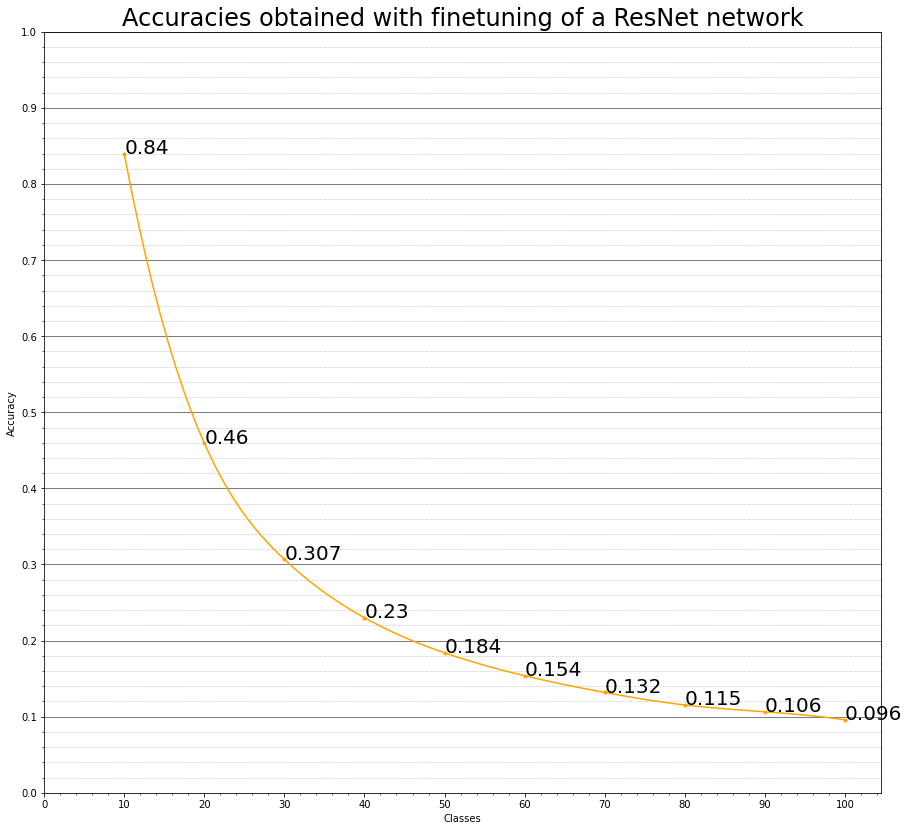

In [0]:
print(test_accuracies)

accuracy_plot(test_accuracies)
#obtained [0.844, 0.4525, 0.2976666666666667, 0.224, 0.1808, 0.1535, 0.125, 0.113625, 0.10577777777777778, 0.0929]